# Heat Equation PDE - Neural Network Solution

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [ ]:
tf.keras.backend.set_floatx('float64')

In [ ]:
tf.random.set_seed(4155)

## Neural Network Model

### Boundary Condition Function

A solution must satisfy the boundary condition function $u(x)=sin(\pi x)$

In [ ]:
def u(x):
    return tf.sin(np.pi * x)

### Neural Network Architecture

The neural network model consists of three hidden layers and one output layer. Using the model subclass functionality of Keras in TensorFlow, the following model is defined.

In [ ]:
class FF(Model):
  def __init__(self):
    super(FF, self).__init__()
    self.H1 = Dense(64, input_shape= (2,) , activation="tanh")
    self.H2 = Dense(64, activation="tanh")
    self.H3 = Dense(64, activation="tanh")
    self.O = Dense(1)

  def call(self, X):
    X = self.H1(X)
    X = self.H2(X)
    X = self.H3(X)
    return self.O(X)


### Loss
To store the losses of each iteration, the Mean metric is used since we do not perform batch training. This results in each loss saved to the loss storage object being just the loss of one iteration. 

The loss function used is mean squared error.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
L = tf.keras.losses.MeanSquaredError()

### Optimizer

The optimizer algorithm used is ADAM.

In [ ]:
optimizer = tf.keras.optimizers.Adam()

### Trial Equation

`g_hat` is the trial solution for the PDE, and `trial_equation` is the heat equation equivalent when `g_hat` is the unknown function in the PDE.

$$\hat{g}(x, t) = (1 - t)u(x) + x (1 - x) t N(x, t)$$ 

where N(x, t) is the neural network model output.

The trial equation is then:
$$\frac{\partial \hat{g}}{\partial t} - \frac{\partial ^2 \hat{g}}{\partial^2 x}=0$$

and the loss is 
$$|| \frac{\partial \hat{g}}{\partial t} - \frac{\partial ^2 \hat{g}}{\partial^2 x} - 0||^2$$

In [ ]:
@tf.function
def trial_equation(X, N):
  x = X[:, 0, None]
  t = X[:, 1, None]
  with tf.GradientTape() as d:
    d.watch(x)
    d.watch(t)
    with tf.GradientTape() as d2:
      d2.watch(x)
      d2.watch(t)
      g_hat = (1 - t) * u(x) + x * (1 - x) * t * N
    dg_dx, dg_dt = d2.gradient(g_hat, [x, t])
  d2g_dx2 = d.gradient(dg_dx, x)
  g_t = dg_dt - d2g_dx2
  return g_t

### Training

At each iteration, estimate the trial equation and evaluate loss. 

In [ ]:
@tf.function
def train_step(X, y, model):
  with tf.GradientTape() as d:
    N = model(X)
    y_hat = trial_equation(X, N)
    loss = L(y, y_hat)
  gradients = d.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss([loss])

## Application

The heat equation is solved on the grid $[0, T] \times [0, L_x]$ with uniformly spaced points. The coordinate in $x$ is the position of a rod of length $L_x$, and the time runs from $0$ to $T$.

Setting up the problem for $T = L_x = 1.0$ and $N = 100$ in each dimension, which equals $N^2 = 10 000$ points in total:

In [ ]:
L_x = 1.0
T = 1.0
N_points = 100

x_p = np.linspace(0.0, L_x, N_points)
t_p = np.linspace(0.0, T, N_points)
T_g, X_g = np.meshgrid(t_p, x_p)

x = X_g.ravel()
t = T_g.ravel()

x = tf.convert_to_tensor(x)[:, None]
t = tf.convert_to_tensor(t)[:, None]
zeros = tf.zeros_like(t)

X = tf.concat([x,t],1)

Initialize model, train with 100 000 iterations. 

In [ ]:
model = FF()

In [13]:
num_iter = 100000

for i in range(num_iter):
  train_step(X, zeros, model)
  
  if i % 1000 == 0:
    template = 'Iteration {}, Loss: {}'
    print(template.format(i, train_loss.result()))

  train_loss.reset_states()

Iteration 0, Loss: 11.197550773620605
Iteration 1000, Loss: 0.02600020356476307
Iteration 2000, Loss: 0.005528152920305729
Iteration 3000, Loss: 0.0028790005017071962
Iteration 4000, Loss: 0.0016173881012946367
Iteration 5000, Loss: 0.0010576030472293496
Iteration 6000, Loss: 0.0007677027024328709
Iteration 7000, Loss: 0.0006145871011540294
Iteration 8000, Loss: 0.0005135571700520813
Iteration 9000, Loss: 0.00047178444219753146
Iteration 10000, Loss: 0.00035093797487206757
Iteration 11000, Loss: 0.00029043626273050904
Iteration 12000, Loss: 0.00024090957595035434
Iteration 13000, Loss: 0.0058196960017085075
Iteration 14000, Loss: 0.00016851804684847593
Iteration 15000, Loss: 0.00014261784963309765
Iteration 16000, Loss: 0.00012554877321235836
Iteration 17000, Loss: 0.00011217038991162553
Iteration 18000, Loss: 0.00010119415674125776
Iteration 19000, Loss: 9.740183304529637e-05
Iteration 20000, Loss: 0.0015069941291585565
Iteration 21000, Loss: 0.0006169956177473068
Iteration 22000, Los

## Results

Evaluate the analytical solution to the heat equation:

$$g^{*}(x, t) = e^{-\pi^2 t} \sin(\pi x)$$

and the approximated solution:

$$\hat{g} = (1 - t)\ u(x) + x (1 - x) t \ N_{model}(X)$$

where $X = [x \  t]$ and $N_{model}$ is the neural network model.

In [ ]:
g_analytic = tf.exp(-np.pi**2 * t) * tf.sin(np.pi * x)
g_hat = (1 - t) * u(x) + x * (1 - x) * t * model(X)

The maximum absolute value difference between the analytical and the neural network approximated solution.

In [15]:
diff = tf.abs(g_analytic - g_hat)
print("Max (g_analytic - g_hat)(x, t) = {}".format(np.max(diff.numpy())))

Max (g_analytic - g_hat)(x, t) = 0.16364813737556214


Plot of the solutions:

In [ ]:
G_analytic = tf.reshape(g_analytic, shape=(N_points, N_points))
G_hat = tf.reshape(g_hat, shape=(N_points, N_points))
diff = G_analytic - G_hat

#### The Model Solution

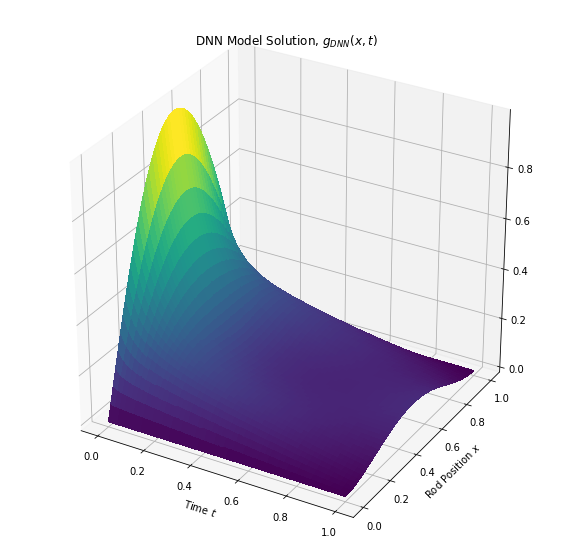

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.set_title("DNN Model Solution, $g_{DNN}(x, t)$")
s = ax.plot_surface(T_g, X_g, G_hat, 
                    linewidth=0, 
                    antialiased=False, 
                    cmap=cm.viridis)
ax.set_xlabel('Time $t$')
ax.set_ylabel('Rod Position $x$');

#### The Analytical Solution

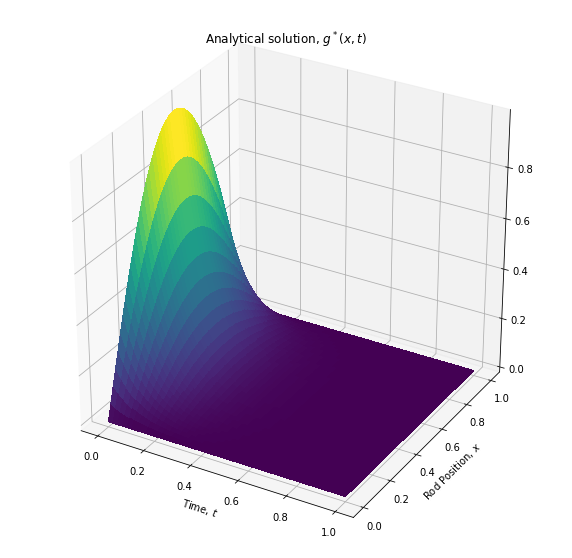

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.set_title('Analytical solution, $g^*(x, t)$')
s = ax.plot_surface(T_g, X_g, G_analytic,
                    linewidth=0,
                    antialiased=False,
                    cmap=cm.viridis)

ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rod Position, $x$');

#### $g^*(x, t) - g_{DNN}(x, t)$

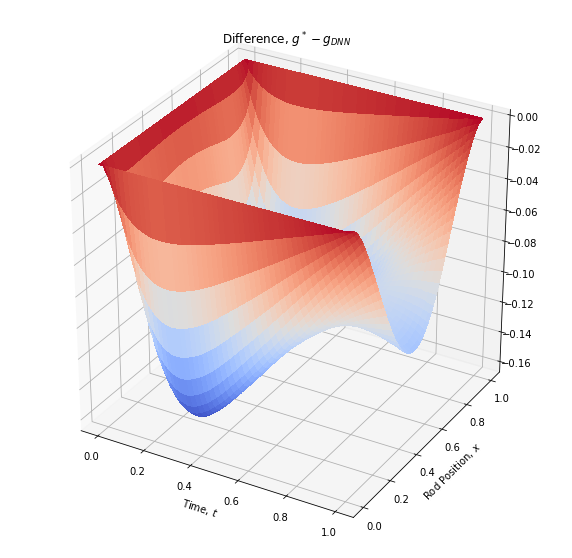

In [19]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.set_title('Difference, $g^* - g_{DNN}$')
s = ax.plot_surface(T_g, X_g, diff,
                    linewidth=0,
                    antialiased=False,
                    cmap=cm.coolwarm)

ax.set_xlabel('Time, $t$')
ax.set_ylabel('Rod Position, $x$');

### Saving the weights

In [20]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
model.save_weights('drive/My Drive/Colab Notebooks/models/HeatEquation_DNN.hf5')